# Insurance AI Model

This notebook aims to use the preprocessed data and predict settlementValue

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import product
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

In [18]:
df_encoded = pd.read_csv('PreprocessedJackExtra.csv')

df_encoded

,SettlementValue,GeneralFixed,Vehicle Age,Driver Age,Number of Passengers,ClaimDelayDays,Injury_Prognosis_Months,AccidentType_Other side changed lanes and collided with clt's vehicle,AccidentType_Other side changed lanes on a roundabout colliding with clt's vehicle,AccidentType_Other side collided with Clt's parked vehicle,...,Accident Description_Unknown,Injury Description_Fractured arm and leg.,Injury Description_Minor cuts and scrapes.,Injury Description_Sprained ankle and wrist.,Injury Description_Unknown,Injury Description_Whiplash and minor bruises.,Police Report Filed_Yes,Witness Present_Yes,Gender_Male,Gender_Other
0,520.00,520.0,13.0,33.0,4.0,214.0,5.0,False,False,False,...,False,False,False,False,False,True,True,True,True,False
1,870.00,260.0,4.0,45.0,2.0,198.0,2.0,False,False,False,...,False,False,True,False,False,False,True,True,False,False
2,2140.00,840.0,9.0,45.0,4.0,7.0,7.0,False,False,False,...,False,False,False,False,False,True,True,False,False,False
3,520.00,520.0,5.0,62.0,1.0,11.0,4.0,False,False,False,...,False,False,True,False,False,False,True,True,False,False
4,260.00,260.0,9.0,78.0,1.0,12.0,3.0,False,False,False,...,False,False,False,False,False,False,True,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,275.00,260.0,18.0,18.0,3.0,309.0,1.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4996,1074.35,895.0,10.0,70.0,4.0,14.0,8.0,False,False,False,...,False,True,False,False,False,False,True,False,False,False
4997,2020.00,520.0,11.0,43.0,1.0,149.0,6.0,False,False,False,...,False,False,True,False,False,False,False,True,True,False
4998,781.20,520.0,10.0,69.0,1.0,251.0,4.0,False,False,False,...,False,False,False,True,False,False,False,False,False,False


# Train test split

In [19]:
df_encoded = df_encoded.dropna(subset=['SettlementValue']).copy()
X = df_encoded.drop('SettlementValue', axis=1)
y = df_encoded['SettlementValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (3915, 54), Test: (979, 54)


In [20]:
base_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
base_model.fit(X_train, y_train)

def evaluate(model, X, y, label='Hold‑out'):
    preds = model.predict(X)
    mae = mean_absolute_error(y, preds)
    rmse = mean_squared_error(y, preds, squared=False)
    mape = np.mean(np.abs((y - preds) / y)) * 100
    r2 = r2_score(y, preds)
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.3f}")
    return mae, rmse, mape, r2

evaluate(base_model, X_test, y_test)

MAE: 495.29, RMSE: 736.30, MAPE: 51.22%, R2: 0.283


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(495.28906069622104, 736.2953230977696, 51.21501476171068, 0.2828081514310766)

In [21]:
ada_model = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),  # use 'estimator' keyword in sklearn ≥1.2
    n_estimators=100,
    learning_rate=0.1,
    random_state=42
)

# 3. Evaluate standalone AdaBoost
print("AdaBoost Performance:")
ada_model.fit(X_train, y_train)
evaluate(ada_model, X_test, y_test)

AdaBoost Performance:
MAE: 663.02, RMSE: 840.85, MAPE: 82.61%, R2: 0.065


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(663.0216599928291, 840.853281496382, 82.60571393650582, 0.06465526092036711)

In [22]:
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 6, 10]
}

results = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for n_est, lr, depth in product(param_grid['n_estimators'], param_grid['learning_rate'], param_grid['max_depth']):
    params = {'n_estimators': n_est, 'learning_rate': lr, 'max_depth': depth}
    print(f'Testing parameters: {params}')
    fold_mae = []
    for train_idx, val_idx in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(
            **params,
            subsample=0.9,
            colsample_bytree=0.9,
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1
        )
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        fold_mae.append(mean_absolute_error(y_val, preds))
    mean_mae = np.mean(fold_mae)
    results.append((params, mean_mae))

results = sorted(results, key=lambda x: x[1])
results[:5]

Testing parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 4}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 6}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 10}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 6}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 10}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 6}
Testing parameters: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 10}
Testing parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 4}
Testing parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 6}
Testing parameters: {'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 10}
Testing parameters: {'n_est

[({'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 6},
  477.37173069168813),
 ({'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 4},
  478.02273778704455),
 ({'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 6},
  478.3454914681738),
 ({'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 4},
  478.7997558380166),
 ({'n_estimators': 300, 'learning_rate': 0.01, 'max_depth': 4},
  479.8891845369497)]

In [23]:
best_params = results[0][0]
print(f"Best params: {best_params}")
best_model = XGBRegressor(
    **best_params,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)
best_model.fit(X_train, y_train)
evaluate(best_model, X_test, y_test)

Best params: {'n_estimators': 400, 'learning_rate': 0.01, 'max_depth': 6}
MAE: 467.75, RMSE: 704.74, MAPE: 47.75%, R2: 0.343


/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(467.7516096248763, 704.7409360119323, 47.75368630348881, 0.3429623463190099)

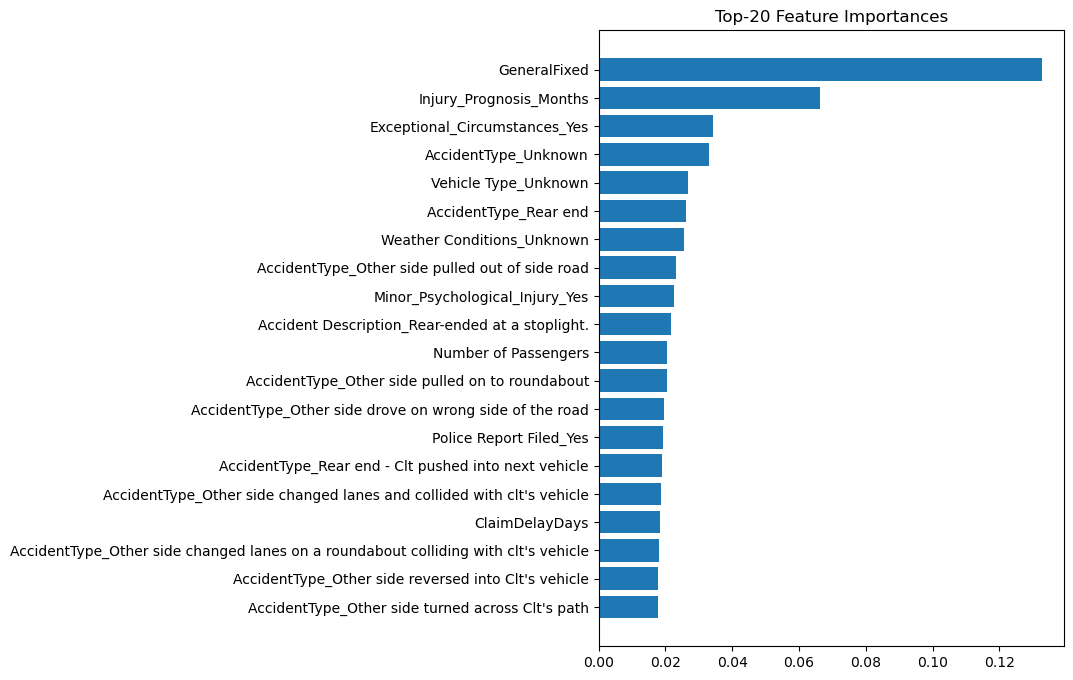

In [24]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[-20:]  # top 20
plt.figure(figsize=(6,8))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.title('Top‑20 Feature Importances')
plt.show()